# Coursework 3 Regression Analysis


## 1. Data Description and Refining 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as sps
import seaborn as sns

In [2]:
df_fs= pd.read_csv("Fire_statistics.csv")
df_fs.replace('\s+', '_',regex=True,inplace=True)
df_fs.head()

,New_code,Local_Authority,Dwelling_fires,Age_over_60,Dependent_children,Long_term_illness,Blind_and_partially_sighted,Deaf_and_hard_of_hearing
0,E09000002,Barking_and_Dagenham,157,26120,5557,185911,810,600
1,E09000003,Barnet,227,64344,8852,356386,1835,1305
2,E09000004,Bexley,143,50007,6952,231997,515,1365
3,E09000005,Brent,240,44944,7368,311215,2310,935
4,E09000006,Bromley,167,70529,9209,309392,1975,2370


In [3]:
df1 = df_fs.drop(['New_code', 'Local_Authority'],axis = 1)

df1.head()


,Dwelling_fires,Age_over_60,Dependent_children,Long_term_illness,Blind_and_partially_sighted,Deaf_and_hard_of_hearing
0,157,26120,5557,185911,810,600
1,227,64344,8852,356386,1835,1305
2,143,50007,6952,231997,515,1365
3,240,44944,7368,311215,2310,935
4,167,70529,9209,309392,1975,2370


## 2. Data Summary Statistics

In [4]:
print (df1.describe())

       Dwelling_fires   Age_over_60  Dependent_children  Long_term_illness  \
count       32.000000     32.000000           32.000000          32.000000   
mean       207.718750  38932.531250         6733.406250      255205.187500   
std         65.326591  12556.070602         1953.022387       55349.945372   
min         92.000000  21433.000000         3178.000000      158649.000000   
25%        156.000000  30832.250000         5475.250000      216078.250000   
50%        216.000000  35681.000000         6777.000000      254326.500000   
75%        243.000000  46463.250000         8221.500000      304063.250000   
max        333.000000  70529.000000        11961.000000      363378.000000   

       Blind_and_partially_sighted  Deaf_and_hard_of_hearing  
count                    32.000000                 32.000000  
mean                   1282.968750                789.687500  
std                     413.606988                538.242267  
min                     515.000000           

In [5]:
# # plot a bar chart
# df_sorted= df_fs.sort_values('Dwelling_fires',ascending=False)
# sns.set_style('darkgrid')
# sns.set(rc={'figure.figsize':(10,9)})
# sns.color_palette("flare", as_cmap=True)
# ax = sns.barplot(x = 'Dwelling_fires', y = 'Local_Authority', data = df_sorted, color = 'c')
# plt.xlabel("Dwelling fire")
# plt.ylabel("Local Authority")
# # plt.title("Dwelling Fires in Each Borough", fontsize = 20)

# plt.savefig('dewlling fire.png', dpi=300, bbox_inches = 'tight')


## 3. Regression Analysis

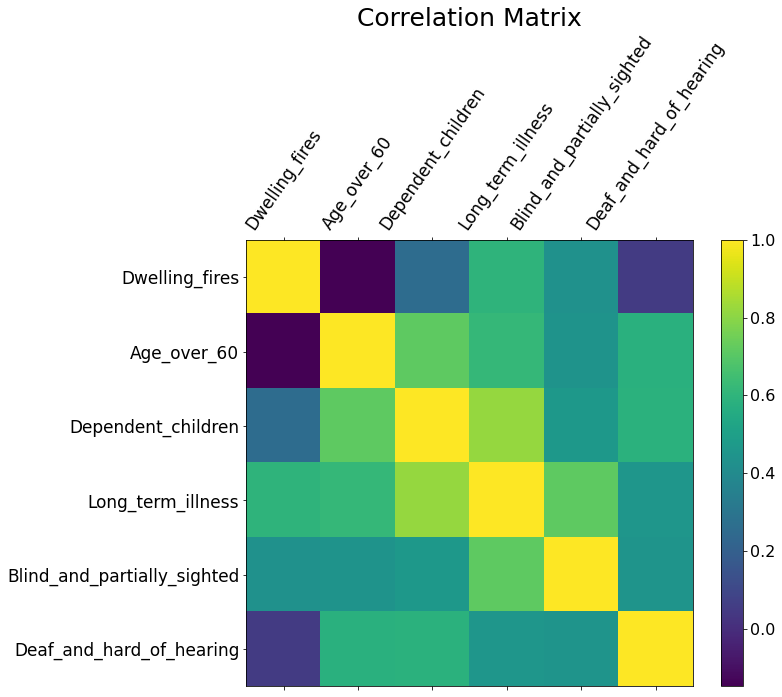

In [6]:
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(10,8))
plt.matshow(df_fs.corr(), fignum=f.number)
plt.xticks(range(df1.shape[1]), df1.columns, fontsize=17, rotation=55)
plt.yticks(range(df1.shape[1]), df1.columns, fontsize=17)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.title('Correlation Matrix', fontsize=25)

plt.savefig('Correlation Matrix.png', dpi=300, bbox_inches = 'tight')


In [7]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df


In [8]:
df_predictors_selected_VIF = drop_column_using_vif_(df1.drop('Dwelling_fires', axis=1))


Dropping: Long_term_illness


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [9]:
df_predictors_selected_VIF.columns


Index(['Age_over_60', 'Dependent_children', 'Blind_and_partially_sighted',
       'Deaf_and_hard_of_hearing'],
      dtype='object')

In [10]:
model_df = sm.OLS(endog=df1[['Dwelling_fires']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_df.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Dwelling_fires   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     6.646
Date:                Mon, 17 Jan 2022   Prob (F-statistic):           0.000738
Time:                        21:25:59   Log-Likelihood:                -167.67
No. Observations:                  32   AIC:                             345.3
Df Residuals:                      27   BIC:                             352.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         125.6532     37.732      3.330      0.003      48.233     203.074
Age_over_60                    -0.0040      0.001     -3.716      0.001      -0.006      -0.002
Dependent_children              0.0207      0.007      2.989      0.006       0.006       0.035
Blind_and_partially_sighted     0.0833      0.025      3.293      0.003       0.031       0.135
Deaf_and_hard_of_hearing       -0.0128      0.022     -0.589      0.561      -0.057       0.032
==============================================================================
Omnibus:                        2.365   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.307   Jarque-Bera (JB):                1.380
Skew:                           0.195   Prob(JB):                        0.502
Kurtosis:                       2.061   Cond. No.                     1.78e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

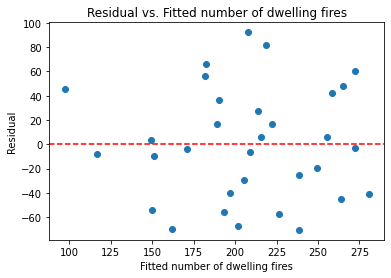

<Figure size 432x288 with 0 Axes>

In [11]:
plt.scatter(model_df.fittedvalues, model_df.resid)
# adding title and labels
plt.xlabel('Fitted number of dwelling fires')
plt.ylabel('Residual')
plt.axhline(y=0, linestyle='dashed', color='r')
# draw a horizontal line
# https://pythonguides.com/matplotlib-dashed-line/
plt.title('Residual vs. Fitted number of dwelling fires')
plt.show()

plt.savefig('Residual vs. Fitted number of dwelling fires.png', dpi=300, bbox_inches = 'tight')


## 4. Standardization

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(df1)
df_std = scaler.transform(df1)

# df_std


In [14]:
df_std = pd.DataFrame(df_std, columns = df1.columns)
df_std.head()

,Dwelling_fires,Age_over_60,Dependent_children,Long_term_illness,Blind_and_partially_sighted,Deaf_and_hard_of_hearing
0,-0.788811,-1.036753,-0.611990,-1.271961,-1.161820,-0.358059
1,0.299874,2.056223,1.102135,1.857270,1.356032,0.972718
2,-1.006547,0.896114,0.113717,-0.426008,-1.886470,1.085976
3,0.502059,0.486431,0.330128,1.028114,2.522841,0.274296
4,-0.633284,2.556695,1.287853,0.994651,1.699934,2.983042


In [15]:
df2= pd.DataFrame(df_std)
df3=df2.drop(columns='Dwelling_fires')

df3.head()

,Age_over_60,Dependent_children,Long_term_illness,Blind_and_partially_sighted,Deaf_and_hard_of_hearing
0,-1.036753,-0.611990,-1.271961,-1.161820,-0.358059
1,2.056223,1.102135,1.857270,1.356032,0.972718
2,0.896114,0.113717,-0.426008,-1.886470,1.085976
3,0.486431,0.330128,1.028114,2.522841,0.274296
4,2.556695,1.287853,0.994651,1.699934,2.983042


In [16]:
extracted_col = df1["Dwelling_fires"]
df4 = df3.join(extracted_col)
df4.head()

,Age_over_60,Dependent_children,Long_term_illness,Blind_and_partially_sighted,Deaf_and_hard_of_hearing,Dwelling_fires
0,-1.036753,-0.611990,-1.271961,-1.161820,-0.358059,157
1,2.056223,1.102135,1.857270,1.356032,0.972718,227
2,0.896114,0.113717,-0.426008,-1.886470,1.085976,143
3,0.486431,0.330128,1.028114,2.522841,0.274296,240
4,2.556695,1.287853,0.994651,1.699934,2.983042,167


Text(0.5, 1.0, 'Correlation Matrix')

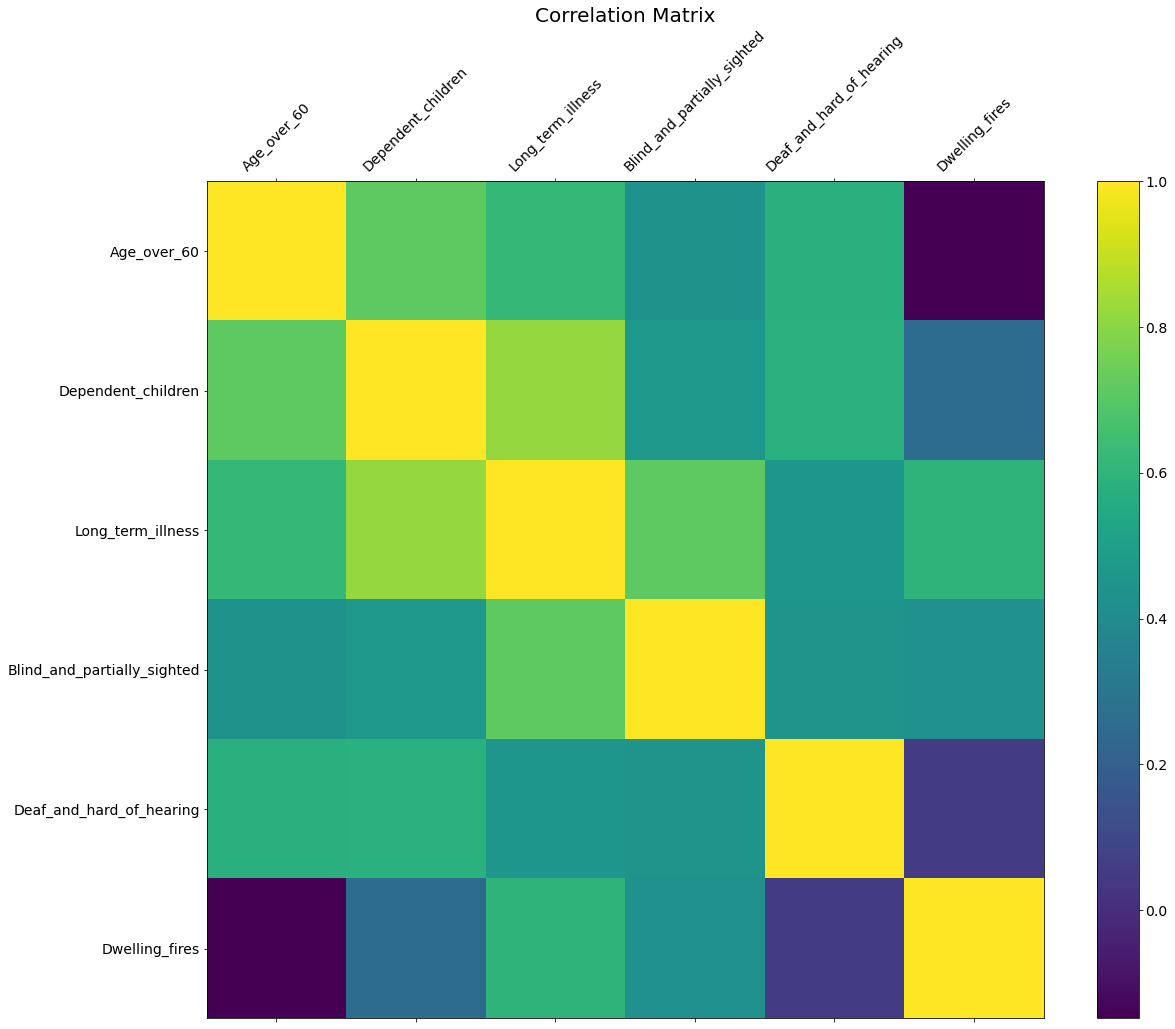

In [17]:
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df4.corr(), fignum=f.number)
plt.xticks(range(df4.shape[1]), df4.columns, fontsize=14, rotation=45)
plt.yticks(range(df4.shape[1]), df4.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=20)


In [18]:
df_predictors_selected_VIF = drop_column_using_vif_(df4.drop('Dwelling_fires', axis=1))
df_predictors_selected_VIF.head()

Dropping: Long_term_illness


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Age_over_60,Dependent_children,Blind_and_partially_sighted,Deaf_and_hard_of_hearing
0,-1.036753,-0.611990,-1.161820,-0.358059
1,2.056223,1.102135,1.356032,0.972718
2,0.896114,0.113717,-1.886470,1.085976
3,0.486431,0.330128,2.522841,0.274296
4,2.556695,1.287853,1.699934,2.983042


In [19]:
model_df = sm.OLS(endog=df4[['Dwelling_fires']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_df.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Dwelling_fires   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     6.646
Date:                Mon, 17 Jan 2022   Prob (F-statistic):           0.000738
Time:                        21:26:01   Log-Likelihood:                -167.67
No. Observations:                  32   AIC:                             345.3
Df Residuals:                      27   BIC:                             352.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         207.7188      8.784     23.648      0.000     189.696     225.742
Age_over_60                   -48.9424     13.172     -3.716      0.001     -75.968     -21.917
Dependent_children             39.8413     13.330      2.989      0.006      12.491      67.192
Blind_and_partially_sighted    33.8934     10.294      3.293      0.003      12.772      55.015
Deaf_and_hard_of_hearing       -6.7926     11.535     -0.589      0.561     -30.461      16.876
==============================================================================
Omnibus:                        2.365   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.307   Jarque-Bera (JB):                1.380
Skew:                           0.195   Prob(JB):                        0.502
Kurtosis:                       2.061   Cond. No.                         3.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

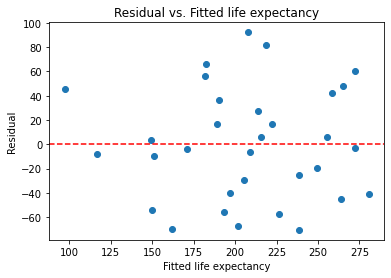

In [20]:
plt.scatter(model_df.fittedvalues, model_df.resid)
# adding title and labels
plt.xlabel('Fitted life expectancy')
plt.ylabel('Residual')
plt.axhline(y=0, linestyle='dashed', color='r')
# draw a horizontal line
# https://pythonguides.com/matplotlib-dashed-line/
plt.title('Residual vs. Fitted life expectancy')
plt.show()

## 5. Clustering Anlysis

In [21]:
import sklearn.cluster as sklc  # For clustering
import sklearn.metrics as sklm 

In [22]:
df5 = df1[['Dwelling_fires', 'Dependent_children']]
df5

,Dwelling_fires,Dependent_children
0,157,5557
1,227,8852
2,143,6952
3,240,7368
4,167,9209
5,203,4650
6,301,11961
7,239,8949
8,238,8435
9,222,7685


In [32]:
# Cluster constituencies based on proportion of electorate voting for each political party

# Cluster repreatedly using 2-10 clusters and find which gives best sillhouette score
cluster_numbers = range(2,11,1)

all_scores = {'n':[], 'ss':[]}

for n in cluster_numbers:
    
    # Create Kmeans object
    kmeans = sklc.KMeans(n_clusters=n, n_init=10)
    
    # Run clusters
    kmeans_output = kmeans.fit(df5)
    clustering_ids_kmeans = kmeans_output.labels_
    
    # Get silhouetter score
    ss = sklm.silhouette_score(df5,clustering_ids_kmeans)
    
    all_scores['n'].append(n)
    all_scores['ss'].append(ss)
    
dfSS = pd.DataFrame(all_scores)

dfSS

,n,ss
0,2,0.556561
1,3,0.532737
2,4,0.566190
3,5,0.552897
4,6,0.536183
5,7,0.536559
6,8,0.537389
7,9,0.533013
8,10,0.548214


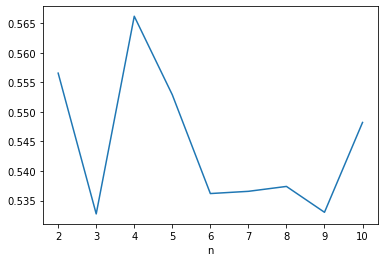

In [33]:
dfSS.set_index('n')['ss'].plot()

plt.savefig('silhouette_score', dpi=300, bbox_inches = 'tight')

In [34]:
# Add clsuter label to data
kmeans_results = sklc.KMeans(n_clusters=4, n_init=3).fit(df5)
# set(list(kmeans_results.labels))
df5['cluster'] = kmeans_results.labels_

cluster_labels_vertical = np.array([kmeans_results.labels_]).T
complete_data_with_clusters = np.hstack((df5, cluster_labels_vertical))

# dd=kmeans_results.labels

# print(complete_data_with_clusters)
# kmeans_results
df5['cluster']

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0     3
1     0
2     3
3     0
4     0
5     1
6     2
7     0
8     0
9     0
10    3
11    1
12    3
13    3
14    3
15    0
16    0
17    1
18    1
19    1
20    0
21    0
22    3
23    3
24    0
25    3
26    0
27    3
28    1
29    3
30    0
31    1
Name: cluster, dtype: int32

In [35]:
data = df5.to_numpy()
data

array([[  157,  5557,     3],
       [  227,  8852,     0],
       [  143,  6952,     3],
       [  240,  7368,     0],
       [  167,  9209,     0],
       [  203,  4650,     1],
       [  301, 11961,     2],
       [  239,  8949,     0],
       [  238,  8435,     0],
       [  222,  7685,     0],
       [  301,  5230,     3],
       [  206,  4318,     1],
       [  219,  6329,     3],
       [  141,  6411,     3],
       [  109,  5997,     3],
       [  176,  8274,     0],
       [  168,  7348,     0],
       [  241,  4396,     1],
       [  153,  3178,     1],
       [   96,  4699,     1],
       [  333,  8220,     0],
       [  230,  8911,     0],
       [  134,  5783,     3],
       [  269,  6611,     3],
       [  169,  7479,     0],
       [   92,  6336,     3],
       [  313,  8226,     0],
       [  137,  5968,     3],
       [  300,  3403,     1],
       [  213,  6943,     3],
       [  261,  7842,     0],
       [  249,  3949,     1]])

In [36]:
# FIGURE PARAMETERS

# Use the next line to set figure height and width (experiment to check the scale):
figure_width, figure_height = 7,7

# These lines set the figure title and axis labels and the font sizes:
fig_title = 'Dwelling fires vs. Dependent children'
x_label   = 'Dependent children'
y_label   = 'Dwelling fires'
title_fontsize = 16
label_fontsize = 12

# These lines set the limits of the x and y axes, so that all plots are on the same scale.
x_min, x_max = 1.12*np.min(data[:,1]), 1.14*np.max(data[:,1])
y_min, y_max = 0.8*np.min(data[:,0]), 1.1*np.max(data[:,0])


# This is a function that sets up each figure's x-limits and y-limits and axis labels.

def setup_figure():
    
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    plt.xlabel(x_label,fontsize=label_fontsize)
    plt.ylabel(y_label,fontsize=label_fontsize)

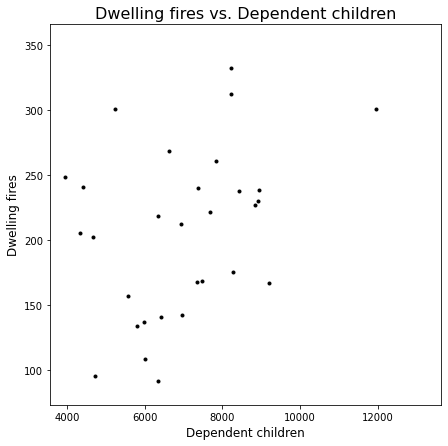

In [37]:
#Let's have a little look at our data from the off. 

#First extract the x and y values from the data:
x_values = data[:,1]
y_values = data[:,0]

#And then a cheeky plot:
plt.figure(0,figsize=(figure_width,figure_height))
setup_figure()
plt.xlabel(x_label,fontsize=label_fontsize)
plt.ylabel(y_label,fontsize=label_fontsize)
plt.title(fig_title,fontsize=title_fontsize)
plt.plot(x_values,y_values, 'k.')

In [38]:
#Now, it would be handy to separate out our data so we have a list of the points within each cluster.  

# The loop below creates a separate data array for each cluster, and puts these arrays together in a list:
data_by_cluster = []

for i in range(4):
    
    this_data = []
    
    for row in complete_data_with_clusters:
        
        if row[-1] == i:
            this_data.append(row)
    
    this_data = np.array(this_data)
    
    data_by_cluster.append(this_data)

# data_by_cluster



In [30]:
# # This is a list of colours to differentiate each cluster.
# color_list = ['b','r','g','m','c','k','y']

# # This loop goes through each cluster, plots it and saves it:
# for i in range(4):
    
#     plt.figure(i+1,figsize=(figure_width,figure_height))
#     setup_figure()
#     plt.title(fig_title + ' - Cluster ' + str(i),fontsize=title_fontsize)
    
#     x_values = data_by_cluster[i][:,1]
#     y_values = data_by_cluster[i][:,0]
    
#     plt.plot(x_values,y_values,color_list[i % 4] + '.')
  

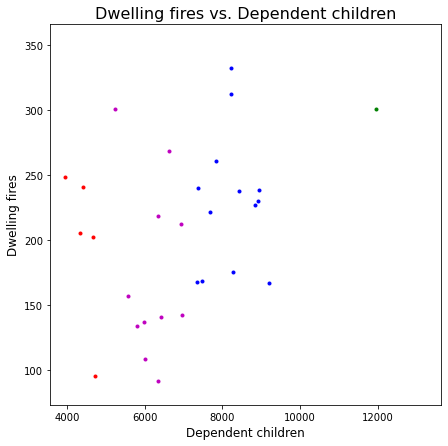

In [39]:

color_list = ['b','r','g','m','c','k','y']

# These lines create a plot with all the data points, coloured by cluster.
plt.figure(i+1,figsize=(figure_width,figure_height))
setup_figure()
plt.title(fig_title,fontsize=title_fontsize)

for i in range(4):
    
    x_values = data_by_cluster[i][:,1]
    y_values = data_by_cluster[i][:,0]
    
    plt.plot(x_values,y_values,color_list[i % 4] + '.')
    

plt.savefig('clustering', dpi=300, bbox_inches = 'tight')